In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import json

from utils.dlt import *
from utils.files import FileName
from utils.skeleton_keypoints import *
from utils.motion_visualize_tool import *

In [2]:
with open("cube/subsets.json", "r") as f:
    subsets = json.load(f)

imgpoints = []
for i in ["1", "4"]:
    imgpoints.append(subsets[f"{i}.mp4"])
imgpoints = np.array(imgpoints, dtype=np.float32)

In [3]:
with open("cube/3d_points.json", "r") as f:
    points = json.load(f)
cube_3d = np.array(points["object_point"], dtype=np.float32)
objpoints = np.array([cube_3d for _ in range(len(imgpoints))] , dtype=np.float32)

In [4]:
print(f"imgpoints: {imgpoints.shape}")
print(f"objpoints: {objpoints.shape}")

imgpoints: (2, 8, 2)
objpoints: (2, 8, 3)


In [5]:
cam = 2

p1 = prepare_matrix(imgpoints[0], objpoints[0])
p2 = prepare_matrix(imgpoints[1], objpoints[1])
P = np.array([p1, p2], dtype=np.float32)

cube_array = pose_recon_2c(cam, P, imgpoints)

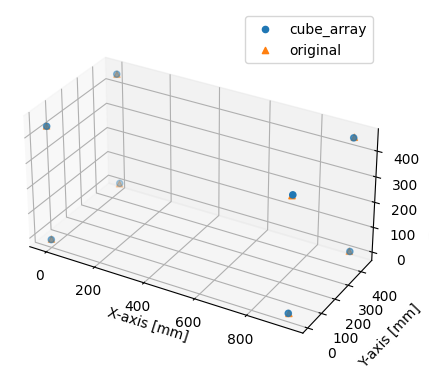

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_array[:, 0], cube_array[:, 1], cube_array[:, 2], marker='o', label='cube_array')
ax.scatter(cube_3d[:, 0], cube_3d[:, 1], cube_3d[:, 2], marker='^', label='original')
ax.set_xlabel('X-axis [mm]')
ax.set_ylabel('Y-axis [mm]')
ax.set_zlabel('Z-axis [mm]')
ax.legend()
ax.set_aspect('equal')
plt.show()

In [7]:
data_num = 0

camera_name1 = "1"
camera_name2 = "4"

cam1_dir = f"data/hirasaki_{camera_name1}_{data_num}/"
cam2_dir = f"data/hirasaki_{camera_name2}_{data_num}/"

cam1_position = pd.read_csv(os.path.join(cam1_dir, FileName.position_data), index_col="frame")
cam2_position = pd.read_csv(os.path.join(cam2_dir, FileName.position_data), index_col="frame")

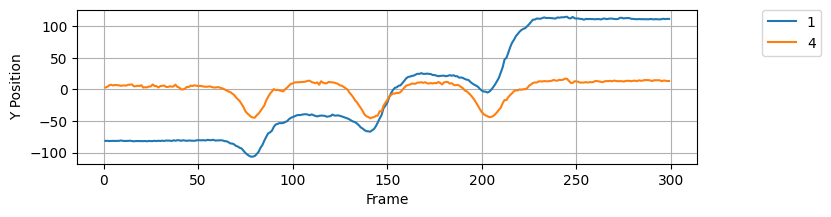

In [8]:
name = "LEFT_ANKLE"

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(cam1_position.index, cam1_position[f"{name}_y"] - cam1_position[f"{name}_y"].mean(), label=camera_name1)
ax.plot(cam2_position.index, cam2_position[f"{name}_y"] - cam2_position[f"{name}_y"].mean(), label=camera_name2)
ax.grid()
ax.set_xlabel('Frame')
ax.set_ylabel('Y Position')
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
plt.show()

In [9]:
df_camera_sync = pd.read_csv("camera_sync.csv")

toe_off_1 = df_camera_sync["toe_off_1"].iloc[data_num]
toe_off_2 = df_camera_sync["toe_off_4"].iloc[data_num]

delay_1 = toe_off_1 - toe_off_1
delay_2 = toe_off_2 - toe_off_1

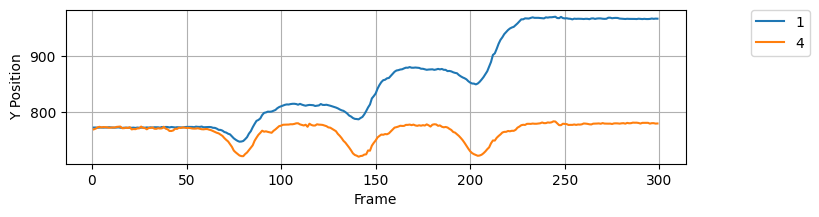

In [10]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(cam1_position.index - delay_1, cam1_position[f"{name}_y"], label=camera_name1)
ax.plot(cam2_position.index - delay_2, cam2_position[f"{name}_y"], label=camera_name2)
ax.grid()
ax.set_xlabel('Frame')
ax.set_ylabel('Y Position')
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
plt.show()

In [11]:
cam1_position["ID"] = cam1_position.index - delay_1
cam2_position["ID"] = cam2_position.index - delay_2

In [12]:
cam1_position = cam1_position.loc[cam1_position["ID"] > 0]
cam2_position = cam2_position.loc[cam2_position["ID"] > 0]

In [13]:
cam1_position.set_index("ID", inplace=True, drop=True)
cam2_position.set_index("ID", inplace=True, drop=True)

In [14]:
min_frame = max(cam1_position.index.min(), cam2_position.index.min())
max_frame = min(cam1_position.index.max(), cam2_position.index.max())

print(min_frame, max_frame)

1.0 299.0


In [15]:
frame = min_frame
cam1_pose = cam1_position.loc[frame].values.reshape(-1, 2)
cam2_pose = cam2_position.loc[frame].values.reshape(-1, 2)
pose = np.array([cam1_pose, cam2_pose], dtype=np.float32)
pose_result = pose_recon_2c(cam, P, pose)

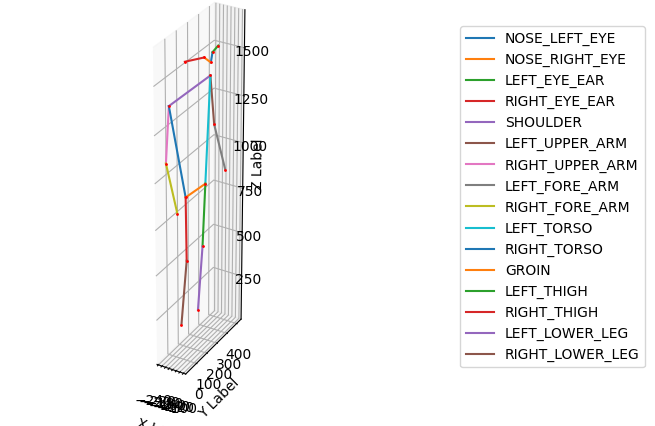

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for key, value in exp_keypoints_connections.items():
    start_idx = value[0]
    end_idx = value[1]
    ax.plot([pose_result[start_idx][0], pose_result[end_idx][0]],
            [pose_result[start_idx][1], pose_result[end_idx][1]],
            [pose_result[start_idx][2], pose_result[end_idx][2]], label=key)
for i in range(len(pose_result)):
    ax.scatter(pose_result[i][0], pose_result[i][1], pose_result[i][2], color='r', s=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
ax.set_aspect('equal')
plt.show()

In [17]:
columns = [f"{kpt}_{xyz}" for kpt in exp_keypoints_list for xyz in ["x", "y", "z"]]
position_df = pd.DataFrame(columns=columns)
position_df.index.name = 'frame'

for frame in range(int(min_frame), int(max_frame) + 1):
    cam1_pose = cam1_position.loc[frame].values.reshape(-1, 2)
    cam2_pose = cam2_position.loc[frame].values.reshape(-1, 2)
    pose = np.array([cam1_pose, cam2_pose], dtype=np.float32)
    pose_result = pose_recon_2c(cam, P, pose)
    position_df.loc[frame] = pose_result.ravel()

position_df

,NOSE_x,NOSE_y,NOSE_z,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_z,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_z,LEFT_EAR_x,...,LEFT_KNEE_z,RIGHT_KNEE_x,RIGHT_KNEE_y,RIGHT_KNEE_z,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_z,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_z
frame,,,,,,,,,,,,,,,,,,,,,
1,-97.623957,150.330779,1548.601742,-106.107719,180.195776,1585.159115,-116.204700,122.121953,1580.953378,-130.292745,...,472.362220,-201.819435,105.938359,487.705194,-234.536671,269.842301,103.217411,-237.638493,114.231639,104.339241
2,-95.658970,153.965813,1549.810651,-104.118518,183.793514,1586.323935,-116.348044,124.154871,1581.999268,-130.544760,...,462.747869,-204.119192,104.536220,478.438395,-235.860247,267.325203,100.915501,-237.606454,114.286938,100.649076
3,-93.896784,155.434032,1550.253684,-104.572453,183.805552,1584.631482,-114.717367,125.816794,1580.431586,-133.205480,...,456.006826,-205.602044,97.756038,471.944140,-236.214663,265.174419,97.042725,-240.168352,111.571249,99.023338
4,-94.562366,158.171004,1548.789541,-104.128202,183.771653,1585.112746,-115.275862,128.379019,1580.973330,-135.080429,...,455.703017,-207.074671,95.845646,472.676955,-237.983043,263.379589,95.197605,-239.555791,111.210627,97.162421
5,-95.436242,158.129923,1549.420876,-102.839771,185.357864,1585.873869,-116.155535,128.322277,1581.613859,-131.447195,...,462.848239,-203.774018,100.078298,476.570895,-236.726289,265.844546,97.007833,-238.413196,113.599107,98.865737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,4488.740728,344.138074,1610.289594,4443.753114,275.506381,1644.606726,4488.019374,355.964329,1652.050657,4417.425166,...,464.511183,4221.359921,181.039758,443.921716,4125.141611,300.307614,56.785573,4151.479844,135.683257,49.424935
296,4485.828244,344.687644,1610.171984,4448.127237,283.256740,1643.469012,4490.225391,359.626548,1649.836513,4427.083824,...,461.152761,4211.966845,162.307492,445.825173,4125.028205,299.513173,54.535787,4151.481109,135.287740,50.421736
297,4490.995921,350.940338,1610.444123,4452.415214,292.499122,1645.140832,4493.568600,362.542933,1652.267814,4414.143705,...,458.717002,4215.666237,171.975982,440.049327,4122.775511,297.545572,55.069005,4151.715918,138.362629,49.489898


In [18]:
plot_3d_motion_exp(position_df/1000, output_name="camera14.html")